This notebooks follows the cell2location tutorial here https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html.
To install cell2location see instruction here https://github.com/BayraktarLab/cell2location.
The only difference is that instead of cell type expression profiles, we use the module expression profiles calculated and saved in this previous notebook (https://github.com/AlexanderAivazidis/cell2fate/blob/main/notebooks/cell2fate_HumanDevelopingBrain.ipynb) as a reference.

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "github"
user = "BayraktarLab"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet cell2location
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


Load and format data:

In [2]:
# Set paths to data and results used through the document (you need to modify this)
sp_data_folder = '/nfs/team283/aa16/data/visium/'
results_folder = '/nfs/team283/aa16/cell2fate_paper_results/HumanDevelopingBrain/'

# create paths and names to results folders:
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [3]:
# Downloading visium data into specified directory:
os.system('cd ' + sp_data_folder + ' && aws --endpoint-url https://cog.sanger.ac.uk --no-sign-request s3 cp s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A . --recursive')

download failed: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/_cmdline to ./_cmdline An error occurred (NoSuchKey) when calling the GetObject operation: Unknown


download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_10_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_10_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_graphclust/clusters.csv to analysis/clustering/gene_expression_graphclust/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_3_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_3_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_2_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_2_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_5_clusters/clust

download failed: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/_invocation to ./_invocation An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
download failed: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/_log to ./_log An error occurred (NoSuchKey) when calling the GetObject operation: Unknown


download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_4_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_4_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_6_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_6_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_7_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_7_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_9_clusters/clusters.csv to analysis/clustering/gene_expression_kmeans_9_clusters/clusters.csv
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/analysis/clustering/gene_expression_kmeans_8_cl

download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/raw_feature_bc_matrix/matrix.mtx.gz to raw_feature_bc_matrix/matrix.mtx.gz
download: s3://cell2fate/spaceranger200_count_45554_AA_DOW13042003-GRCh38-2020-A/possorted_genome_bam.bam to ./possorted_genome_bam.bam


256

In [4]:
# Load previously calculated module steady state expression profiles:
inf_aver = pd.read_csv(results_folder + 'HumanDevelopingBrainmodules.csv', index_col=0)

In [5]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
samples = [""]

# Read the data into anndata objects
slides = []
for i in samples:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=samples,
    index_unique=None
)
#######################

/nfs/team283/aa16/software/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/team283/aa16/software/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
# Fixes a bug for spaceranger 2.0 data:
adata_vis.obsm['spatial'] = adata_vis.obsm['spatial'].astype(int)

In [7]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [8]:
tab = adata_vis.var['SYMBOL'].value_counts()
vnames = tab.index[tab != 2]
adata_vis.var_names = adata_vis.var['SYMBOL']
adata_vis.var = adata_vis.var.drop('SYMBOL', axis = 1)
subset = [g in np.array(vnames) for g in adata_vis.var_names]
adata_vis = adata_vis[:,subset]

In [9]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [10]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team283/aa16/software/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team283/aa16/software/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:14<00:00, 70.21it/s]


'/nfs/team283/aa16/cell2fate_paper_results/HumanDevelopingBrain//cell2location_map/sp.h5ad'

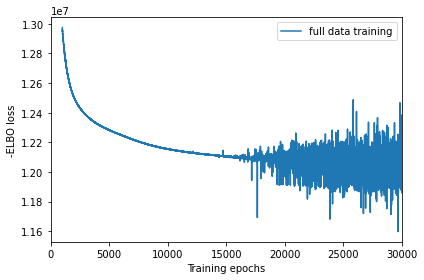

In [11]:
run_name = f'{results_folder}/cell2location_map'

alpha = 20

# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=alpha
)

mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)
mod.plot_history(1000)
plt.legend(labels=['full data training']);
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

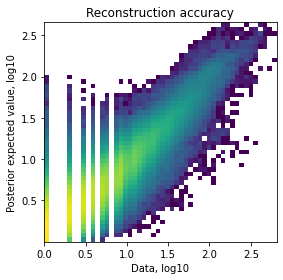

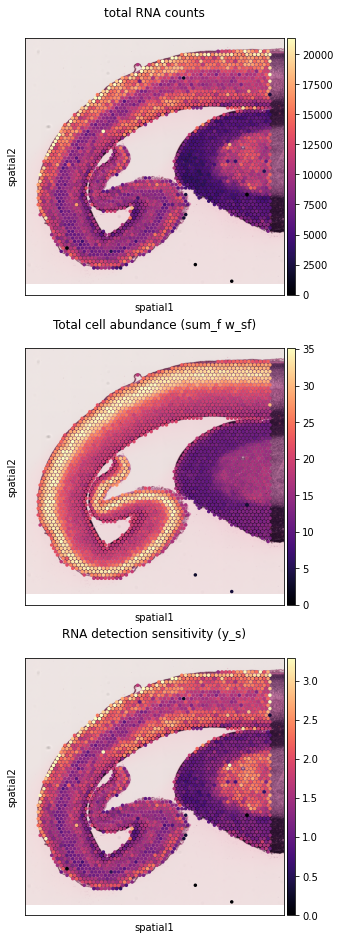

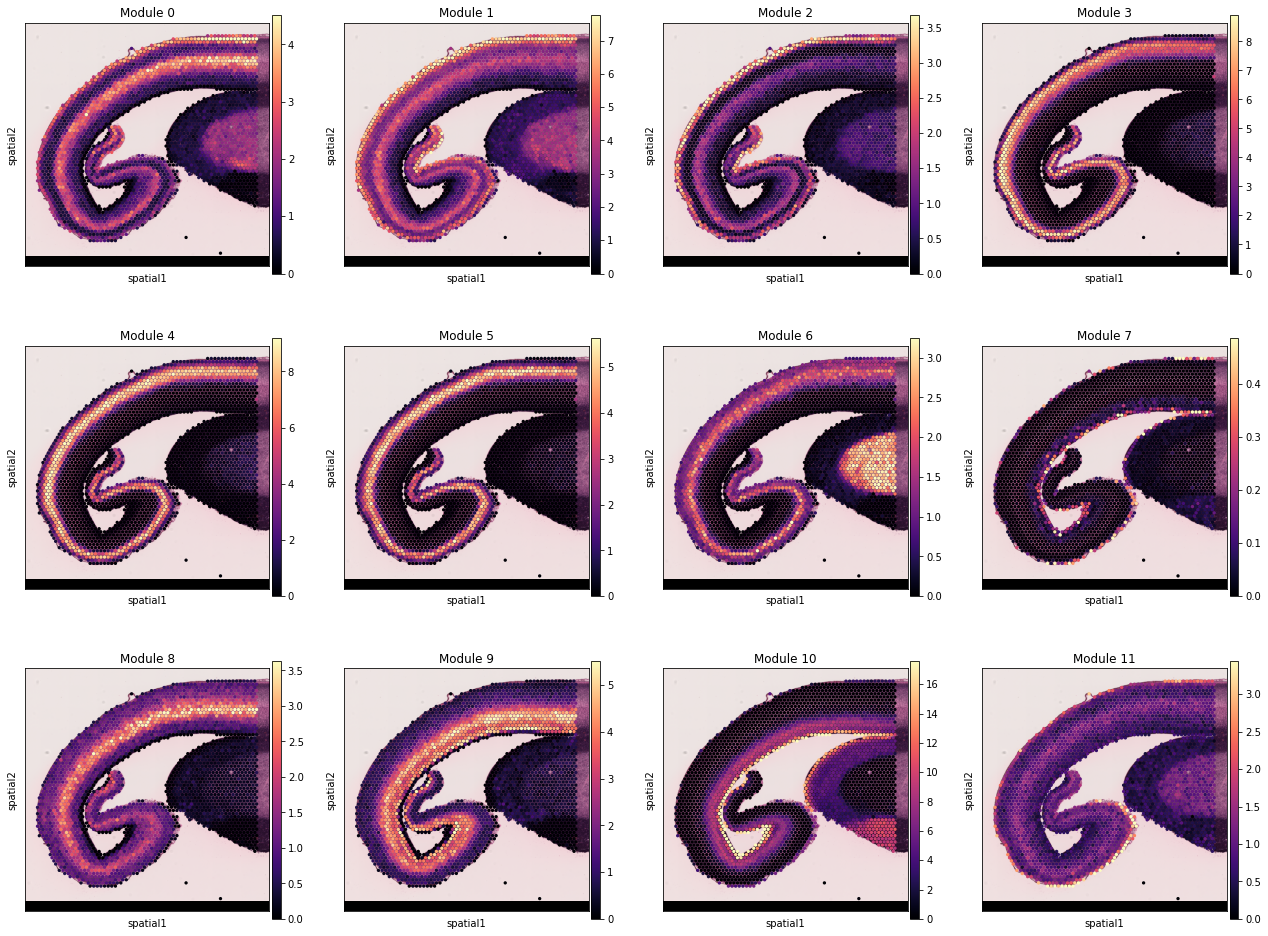

In [12]:
mod.plot_QC()

fig = mod.plot_spatial_QC_across_batches()

celltypes = np.array(inf_aver.columns)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# # select one slide
# from cell2location.utils import select_slide
# slide = select_slide(adata_vis, 'spaceranger130_count_FFPE_42046_AADOW_SP11406634_GRCh38-2020-A')
slide = adata_vis

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=celltypes,
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )
    
#     plt.savefig('AADOW_SP11406634_multicolour_c2lplot_Alpha' + str(alpha) + '.pdf')

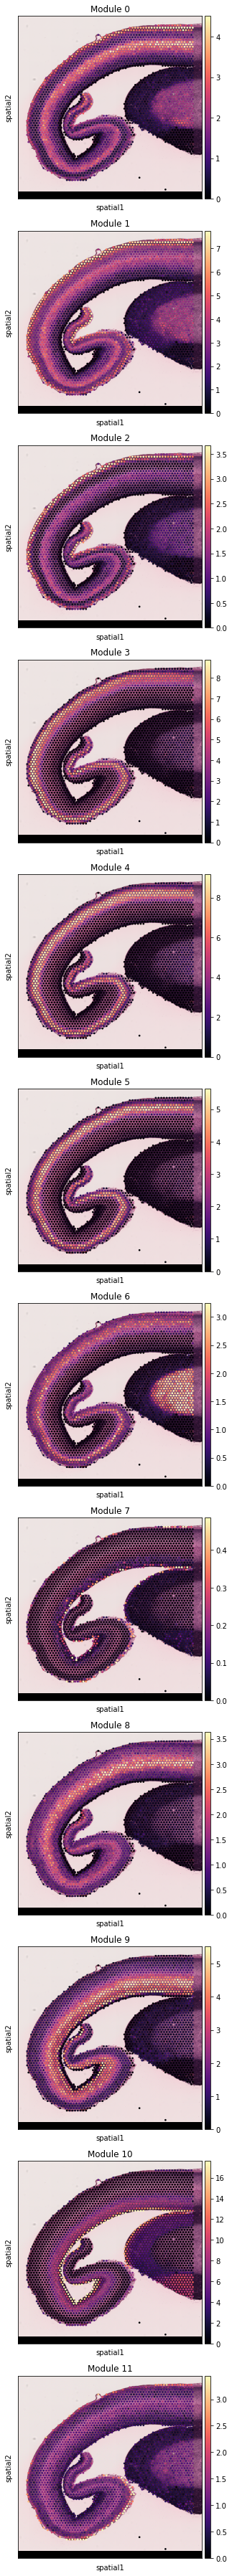

In [13]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    fig, ax = plt.subplots(12,1, figsize = (5,50))
    for i in range(12):
        sc.pl.spatial(slide, cmap='magma',
                          # show first 8 cell types
                          color=celltypes[i],
                          ncols=1,
                          img_key='hires',
                          # limit color scale at 99.2% quantile of cell abundance
                          vmin=0, vmax='p99.2', show = False, ax = ax[i]
                         )
plt.tight_layout()    
#plt.savefig(results_folder + 'cell2location_map.pdf')